In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import random
from sklearn.utils import resample

In [ ]:
data=pd.read_csv('mnli.tsv',sep='\t',header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data=data.rename(columns={0: "id", 1: "premise", 2: "entailment", 3: "target"})

In [ ]:
value = data['target'].value_counts()
print(value)

0    362013
1      2002
Name: target, dtype: int64


In [ ]:
df_majority = data[data['target']==0]
df_minority = data[data['target']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=value[1])
data = pd.concat([df_majority_downsampled,df_minority])

In [ ]:
target=data['target']
data = data.drop(['id'],axis=1)

In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
!pip install transformers
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('success!')

import os
import zipfile

# Download helper functions file
helper_file = drive.CreateFile({'id': '16HW-z9Y1tM3gZ_vFpJAuwUDohz91Aac-'})
helper_file.GetContentFile('helpers.py')
print('helper file downloaded! (helpers.py)')


     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 3.3 MB 68.5 MB/s 
     |████████████████████████████████| 61 kB 736 kB/s 
     |████████████████████████████████| 895 kB 63.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
success!
helper file downloaded! (helpers.py)


In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DebertaTokenizer, DebertaForSequenceClassification
import torch
import numpy as np
model_name = 'cross-encoder/qnli-electra-base'
def load_data(df):
  MAX_LEN = 512
  #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  #tokenizer = AutoTokenizer.from_pretrained(model_name)
  tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
  token_ids = []
  mask_ids = []
  seg_ids = []
  y = []

  premise_list = df['premise'].to_list()
  entailment_list = df['entailment'].to_list()
  label_list = df['target'].to_list()

  for (premise, hypothesis, label) in zip(premise_list, entailment_list, label_list):
    premise=premise[:MAX_LEN]
    hypothesis=hypothesis[:MAX_LEN]
    premise_id = tokenizer.encode(premise, add_special_tokens = False)
    hypothesis_id = tokenizer.encode(hypothesis, add_special_tokens = False)
    pair_token_ids = [tokenizer.cls_token_id] + premise_id + [tokenizer.sep_token_id] + hypothesis_id + [tokenizer.sep_token_id]
    premise_len = len(premise_id)
    hypothesis_len = len(hypothesis_id)

    segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
    attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

    token_ids.append(torch.tensor(pair_token_ids))
    seg_ids.append(segment_ids)
    mask_ids.append(attention_mask_ids)
    if label == 0:
      label = torch.tensor([0.,1.])
    else:
      label = torch.tensor([1.,0.])
    y.append(np.array(label))
    
  token_ids = pad_sequence(token_ids, batch_first=True)
  mask_ids = pad_sequence(mask_ids, batch_first=True)
  seg_ids = pad_sequence(seg_ids, batch_first=True)
  y = torch.tensor(y)
  dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
  #print(len(dataset))
  return dataset


In [ ]:
def get_data_loaders(batch_size=32, shuffle=True):
  train_loader = DataLoader(
    train_data,
    shuffle=shuffle,
    batch_size=batch_size
  )

  val_loader = DataLoader(
    val_data,
    shuffle=shuffle,
    batch_size=batch_size
  )

  return train_loader, val_loader

In [ ]:
 from sklearn.model_selection import train_test_split

 X_train, X_val = train_test_split(data,test_size=0.2, random_state=1)

In [ ]:
train_data = load_data(X_train)
val_data = load_data(X_val)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2,problem_type="multi_label_classification")


# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'config', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [ ]:
batch_size = 32
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 2e-8 
                )
epochs = 5

In [ ]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=16)
val_loader = DataLoader(val_data,shuffle=True,batch_size=16)

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import sklearn
from sklearn.metrics import roc_auc_score

from sklearn.metrics import f1_score

def multi_acc(y_pred, y_test,total_roc,num_iter):
  pred = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
  probs = torch.argmax(y_pred,axis=1)
  
  print('pred',pred)
  acc = (pred == y_test).sum().float() / float(y_test.size(0))
  print('prob',probs)
  
  fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), probs.cpu().numpy())
  
  pyplot.plot([0, 1], [0, 1], linestyle='--')
  pyplot.plot(fpr, tpr)
  pyplot.show()
  #roc_acc = roc_auc_score(y_test.cpu().numpy(),probs.cpu().numpy())
  #print(f1_score(y_test.cpu().numpy(),pred.cpu().numpy()))
  try:
    roc_auc= roc_auc_score(y_test.cpu().numpy(), probs.cpu().numpy())
    total_roc+=roc_auc
    print('roc',roc_auc)
    num_iter+=1
  except ValueError:
    pass
  
  return acc,total_roc,num_iter

import time

EPOCHS = 1




def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    total_roc_1 = 0
    number_of_iter = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc,train_roc,iter_1 = multi_acc(prediction, labels[:,0],total_roc_1,number_of_iter)
      
      #roc_acc = roc_auc_score(labels,prediction,multi_class='ovr')
      #acc = sklearn.accuracy_score(labels,prediction)
      print('acc1',acc)
      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()
      

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    total_roc = 0
    number_of_iter=0

    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc,roc,iter = multi_acc(prediction, labels[:,0],total_roc,number_of_iter)
        #acc = sklearn.accuracy_score(labels,prediction)
        total_val_loss += loss.item()
        total_val_acc  += acc.item()
        number_of_iter +=iter
        total_roc +=roc
        

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print('roc',roc)
    print('num',number_of_iter)
    print('avg',roc/number_of_iter)


pred tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')


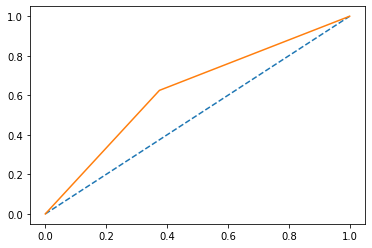

roc 0.625
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


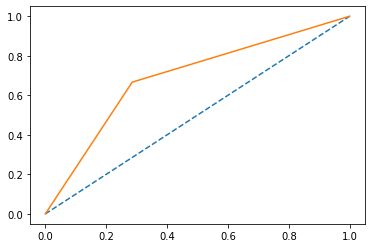

roc 0.6904761904761905
acc1 tensor(0.6875, device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')


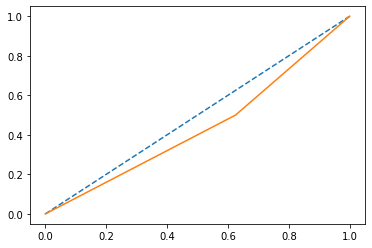

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')


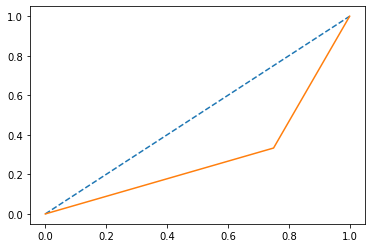

roc 0.29166666666666663
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


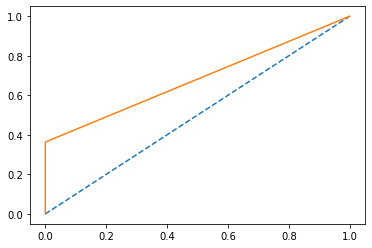

roc 0.6818181818181819
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


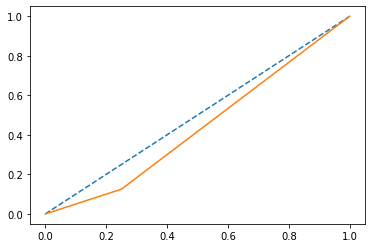

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


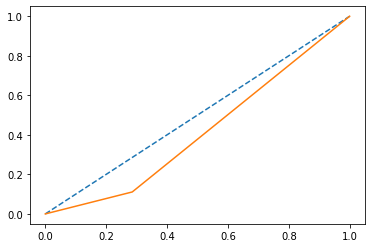

roc 0.41269841269841273
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


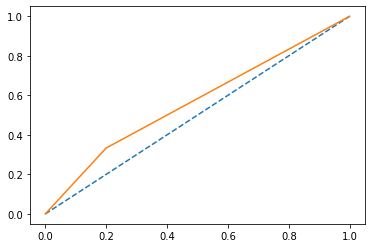

roc 0.5666666666666667
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


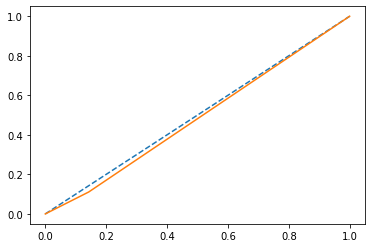

roc 0.4841269841269842
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


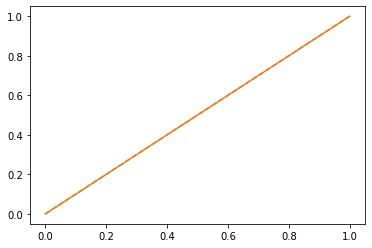

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


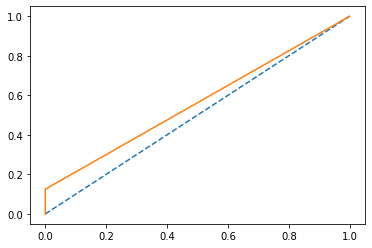

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


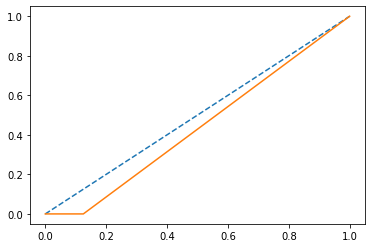

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


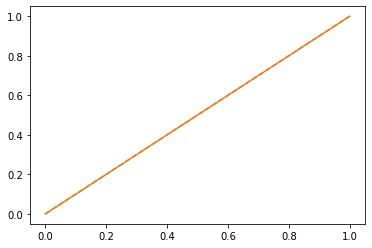

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')


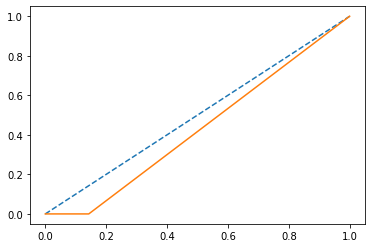

roc 0.4285714285714286
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


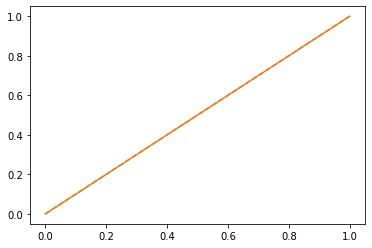

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


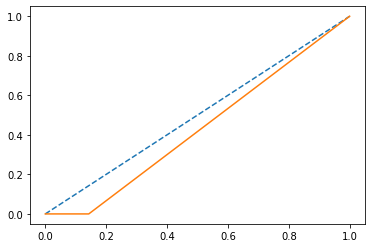

roc 0.4285714285714286
acc1 tensor(0.7500, device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


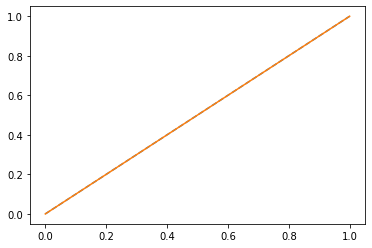

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')


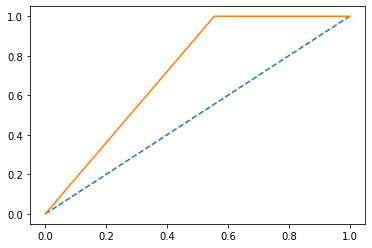

roc 0.7222222222222222
acc1 tensor(0.6875, device='cuda:0')
pred tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


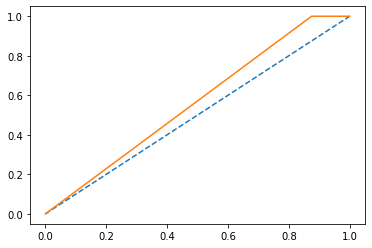

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')


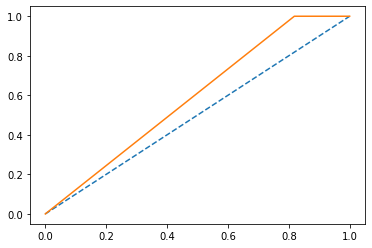

roc 0.5909090909090908
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


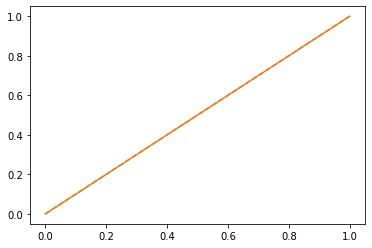

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


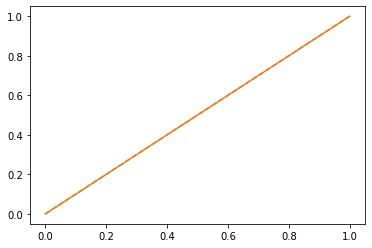

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


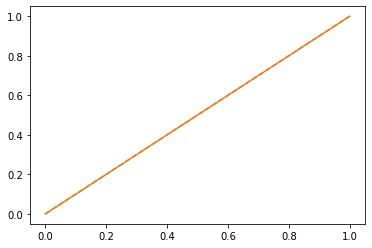

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


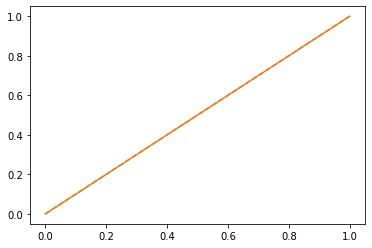

roc 0.5
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


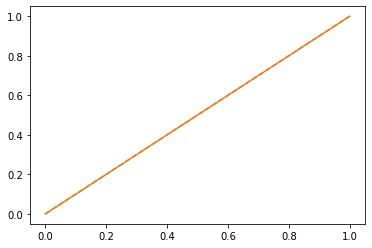

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


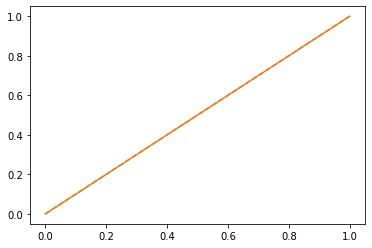

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


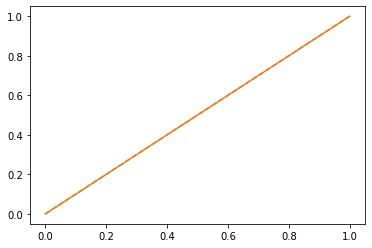

roc 0.5
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


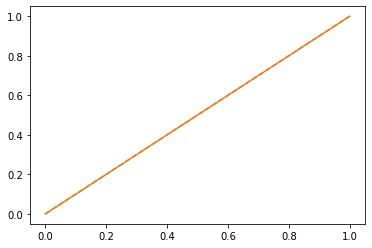

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


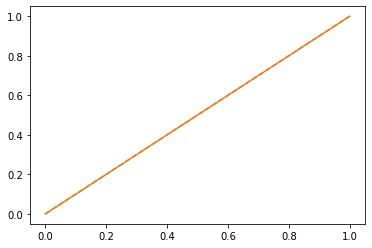

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


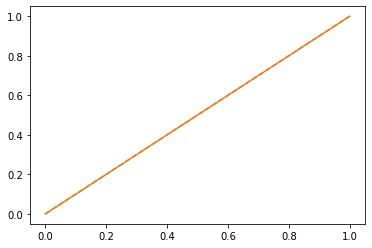

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


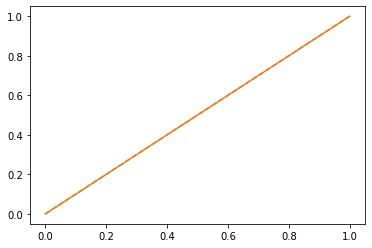

roc 0.5
acc1 tensor(0.2500, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


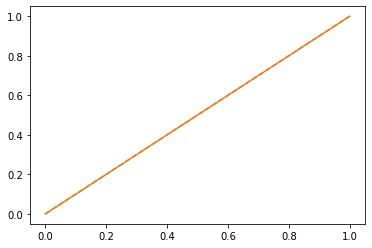

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


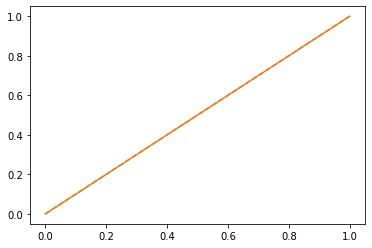

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


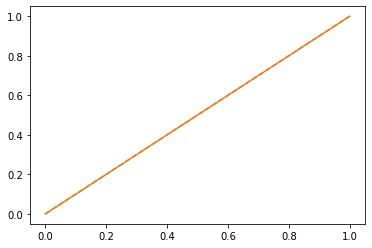

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


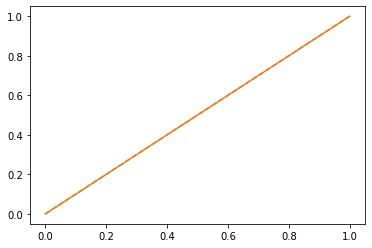

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


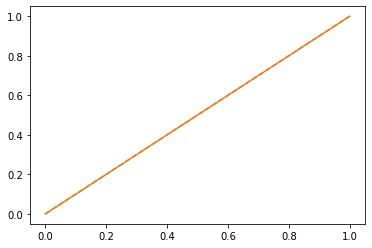

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


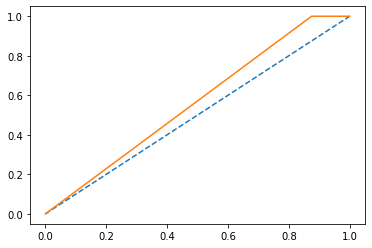

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')


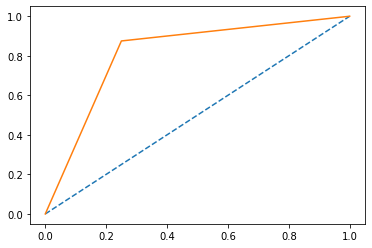

roc 0.8125
acc1 tensor(0.8125, device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')


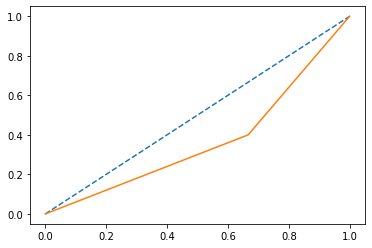

roc 0.3666666666666667
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


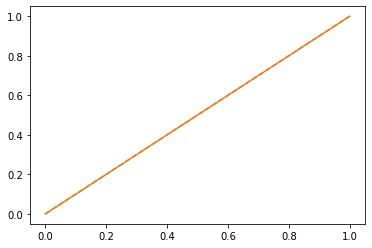

roc 0.5
acc1 tensor(0.2500, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


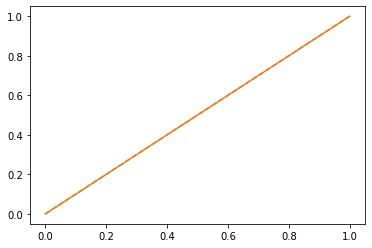

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


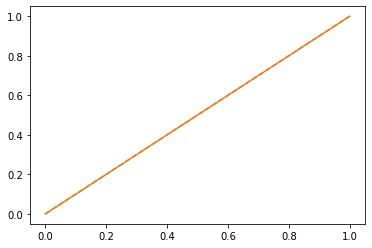

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


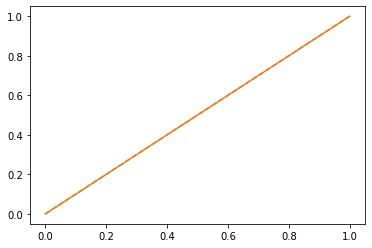

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


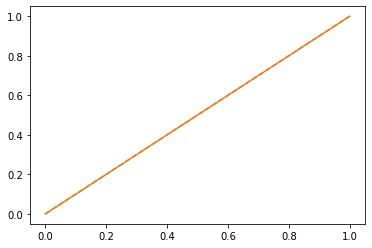

roc 0.5
acc1 tensor(0.8125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


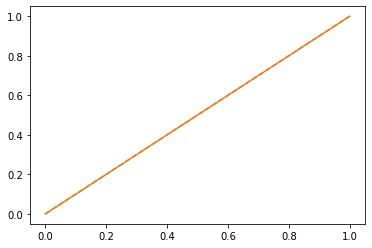

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


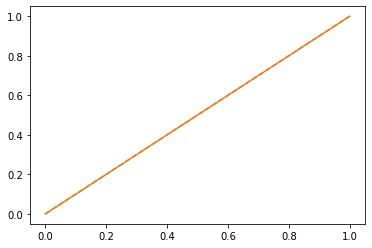

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


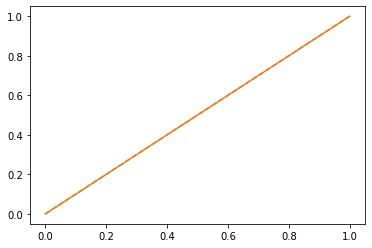

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


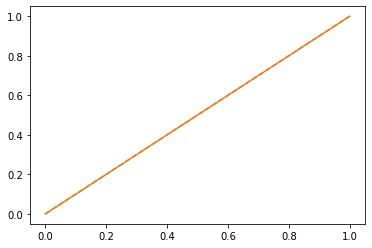

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


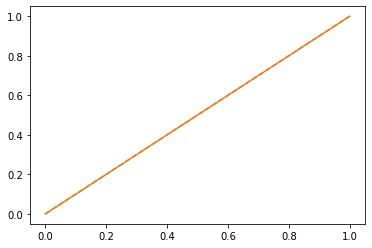

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


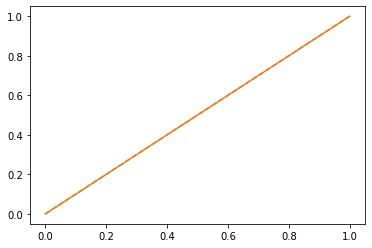

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


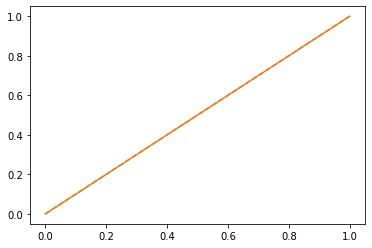

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


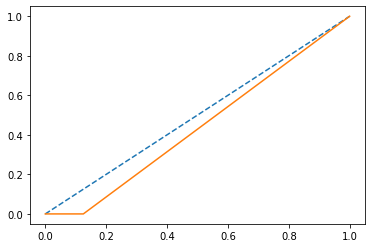

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


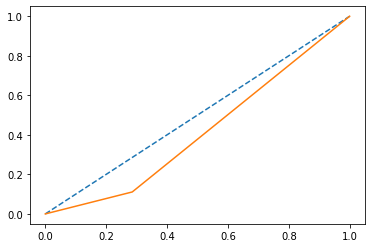

roc 0.41269841269841273
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


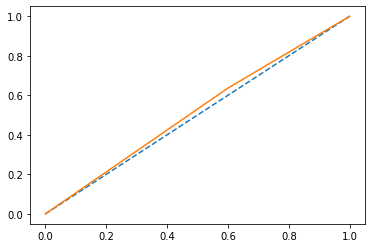

roc 0.5181818181818182
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')


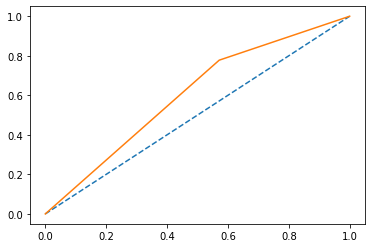

roc 0.6031746031746033
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


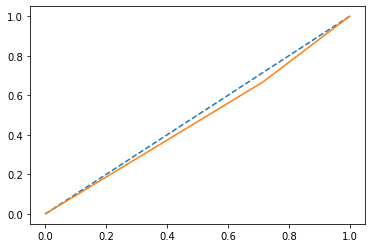

roc 0.47619047619047616
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


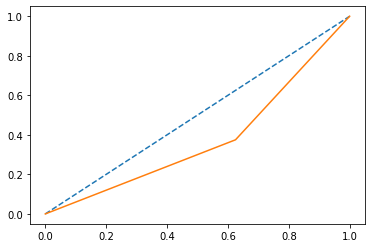

roc 0.375
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')


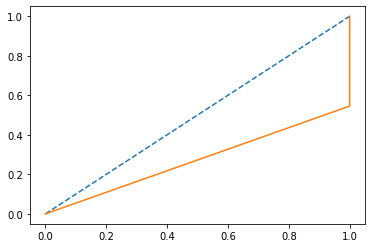

roc 0.2727272727272727
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')


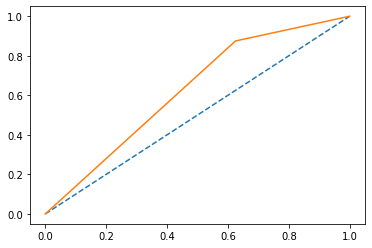

roc 0.625
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')


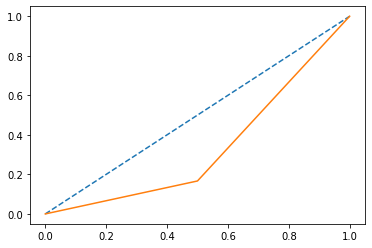

roc 0.33333333333333337
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


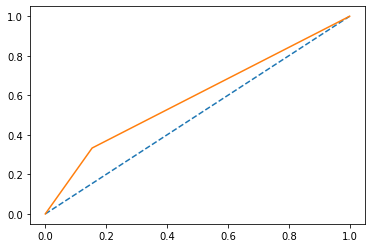

roc 0.5897435897435898
acc1 tensor(0.7500, device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


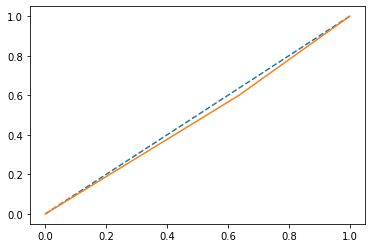

roc 0.4818181818181818
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


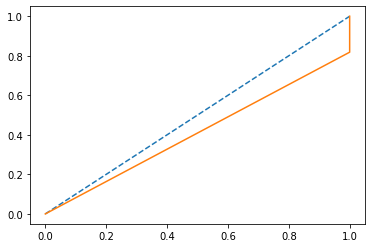

roc 0.4090909090909091
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


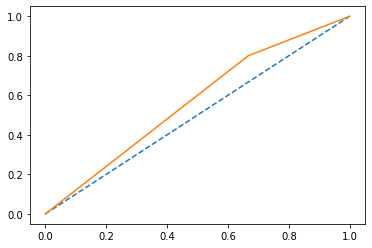

roc 0.5666666666666667
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')


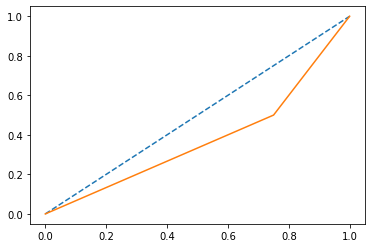

roc 0.375
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')


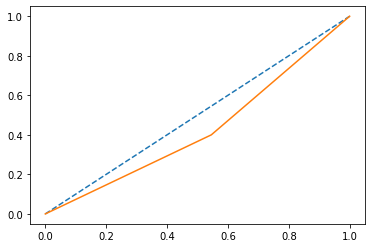

roc 0.42727272727272725
acc1 tensor(0.4375, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')


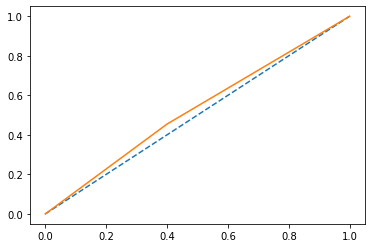

roc 0.5272727272727272
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


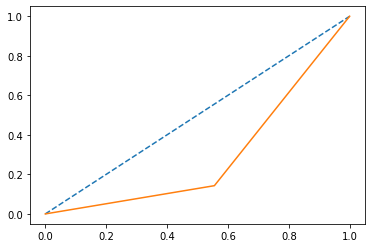

roc 0.2936507936507936
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


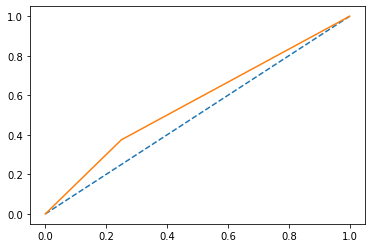

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


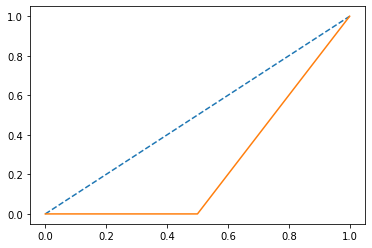

roc 0.25
acc1 tensor(0.2500, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')


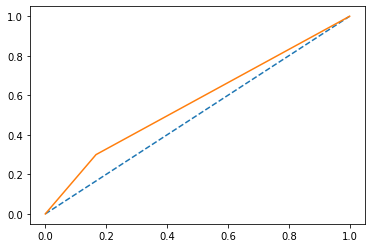

roc 0.5666666666666668
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')


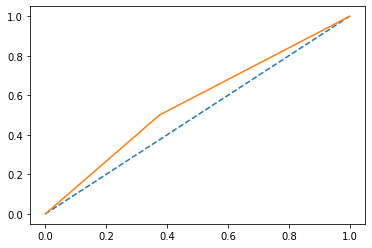

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


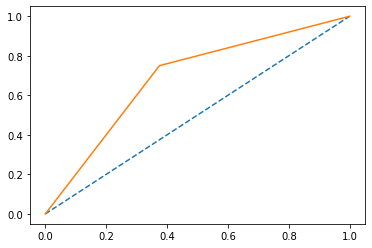

roc 0.6875
acc1 tensor(0.6875, device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')


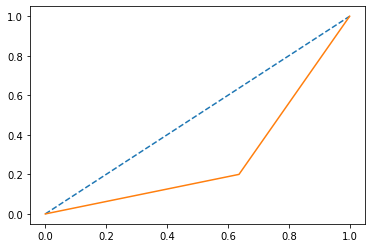

roc 0.2818181818181818
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')


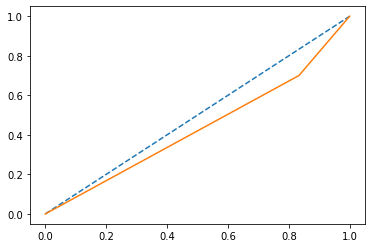

roc 0.43333333333333335
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


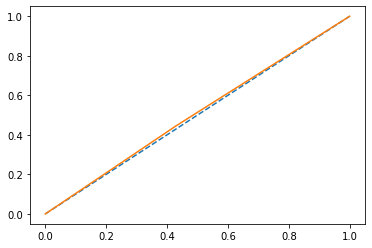

roc 0.5079365079365079
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


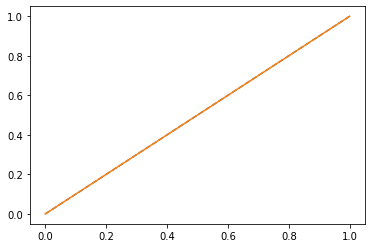

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')


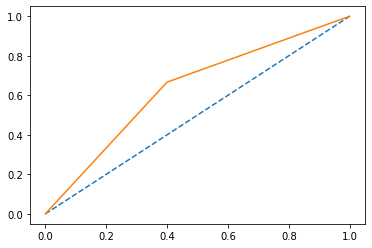

roc 0.6333333333333333
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')


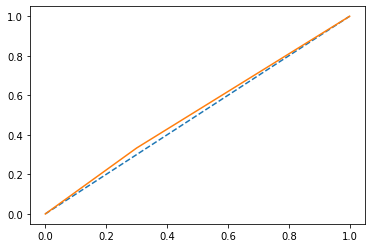

roc 0.5166666666666666
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')


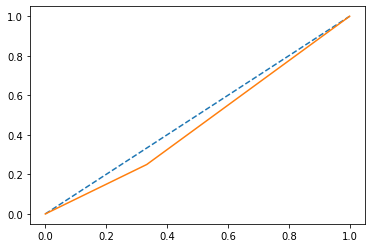

roc 0.4583333333333334
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


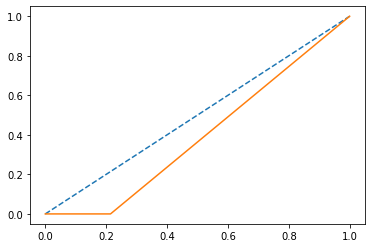

roc 0.39285714285714285
acc1 tensor(0.6875, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


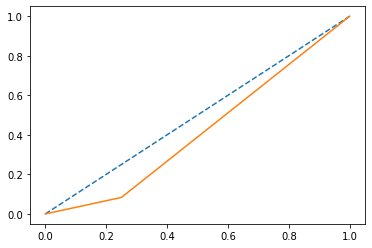

roc 0.4166666666666667
acc1 tensor(0.2500, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


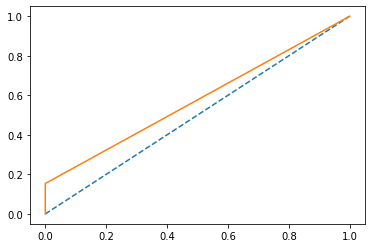

roc 0.5769230769230769
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


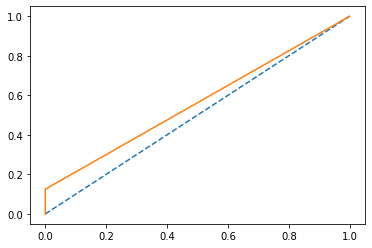

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


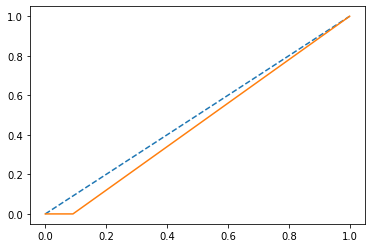

roc 0.45454545454545453
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


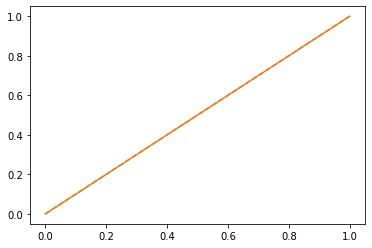

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


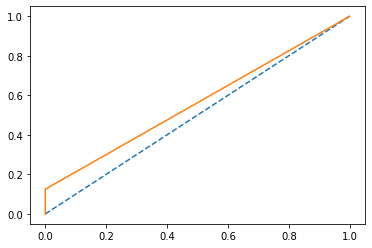

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


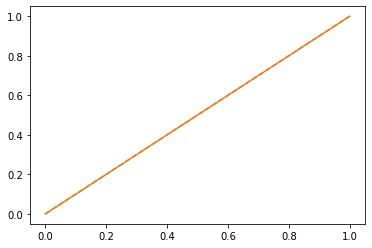

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


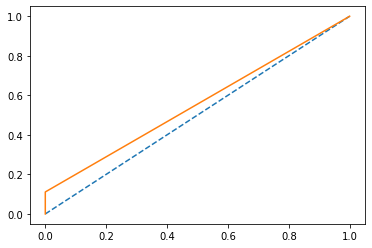

roc 0.5555555555555556
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


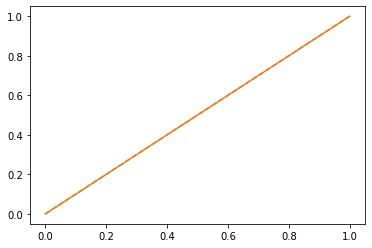

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


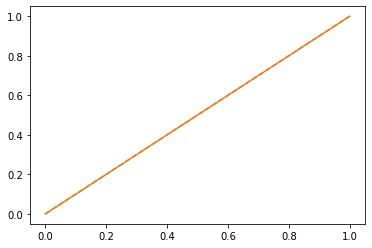

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


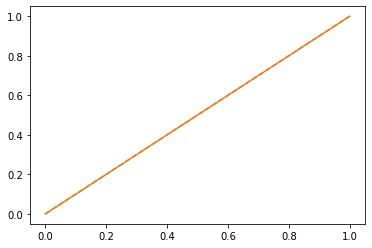

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


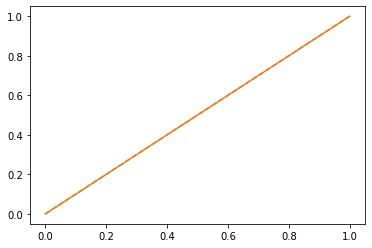

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


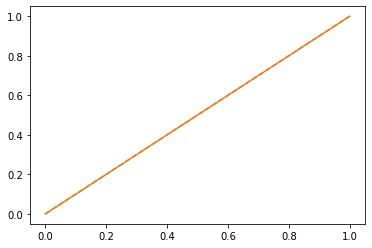

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


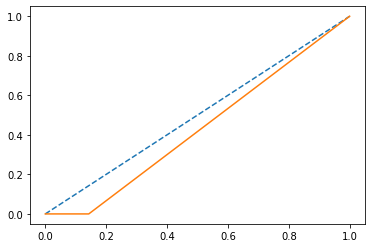

roc 0.4285714285714286
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


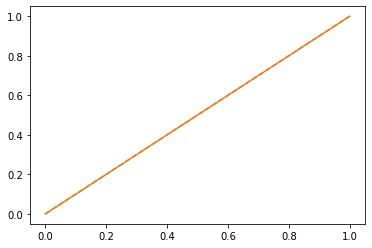

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


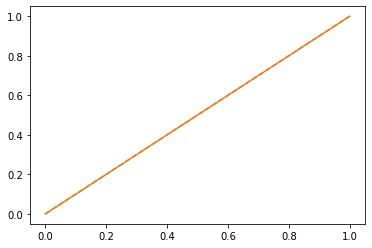

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


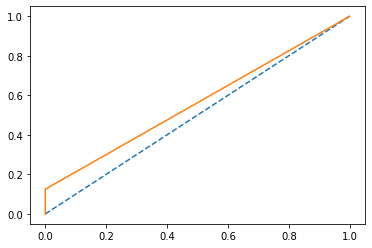

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


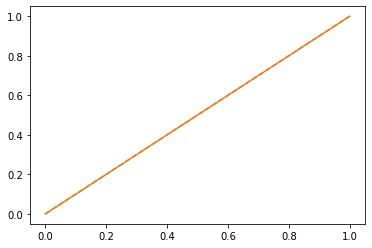

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


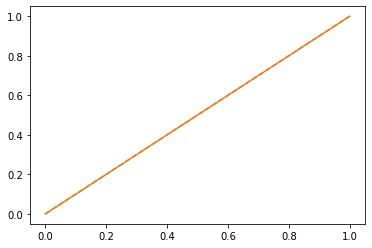

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


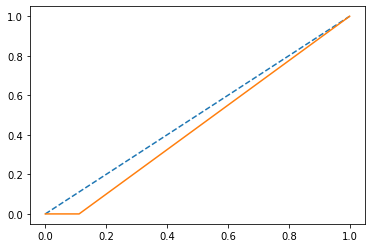

roc 0.4444444444444444
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


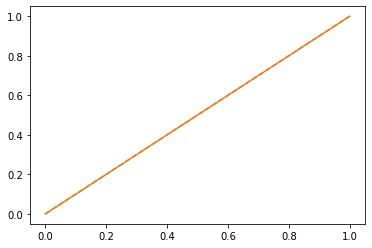

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


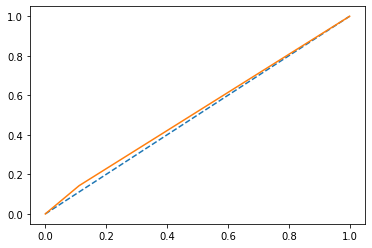

roc 0.5158730158730158
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


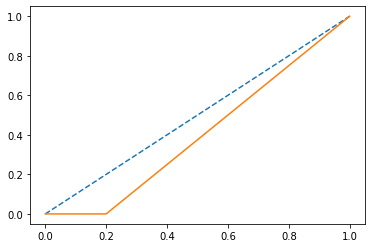

roc 0.4
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')


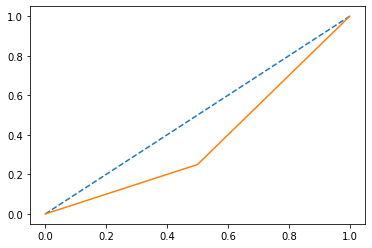

roc 0.375
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


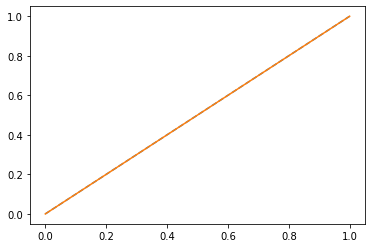

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')


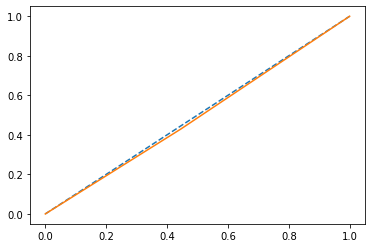

roc 0.4920634920634921
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')


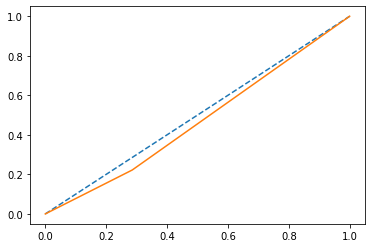

roc 0.4682539682539683
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')


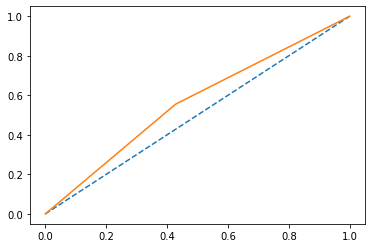

roc 0.5634920634920635
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')


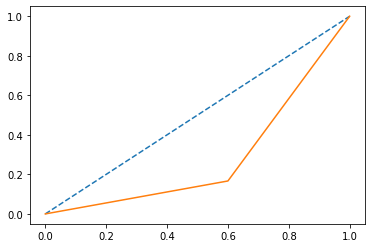

roc 0.2833333333333334
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')


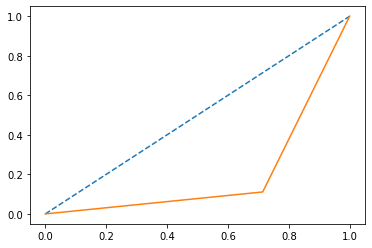

roc 0.1984126984126984
acc1 tensor(0.1875, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')


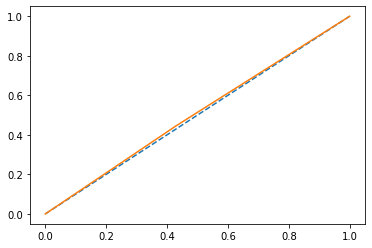

roc 0.5079365079365079
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


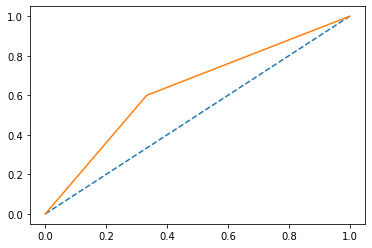

roc 0.6333333333333334
acc1 tensor(0.6250, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


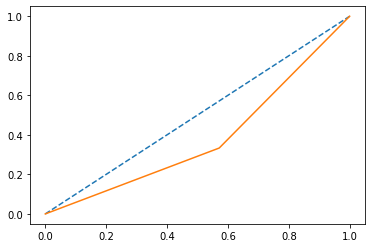

roc 0.38095238095238093
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


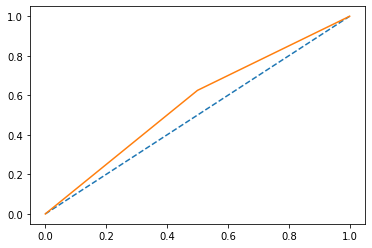

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')


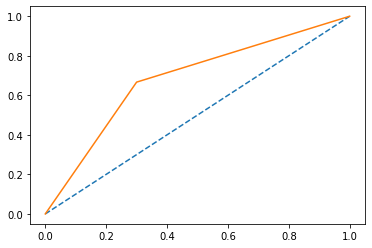

roc 0.6833333333333332
acc1 tensor(0.6875, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')


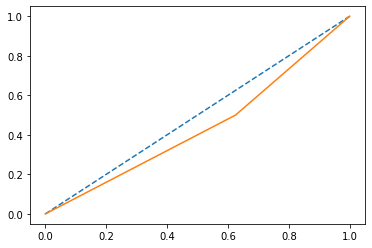

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


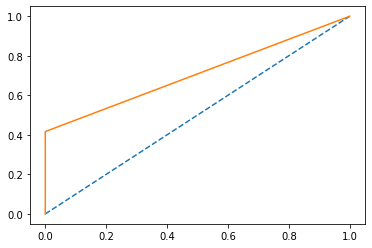

roc 0.7083333333333334
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')


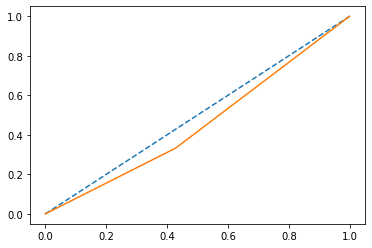

roc 0.45238095238095233
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')


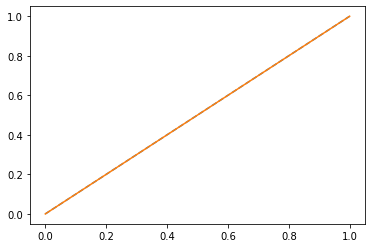

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


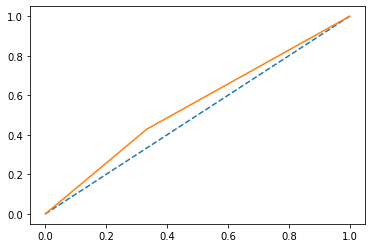

roc 0.5476190476190477
acc1 tensor(0.5625, device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


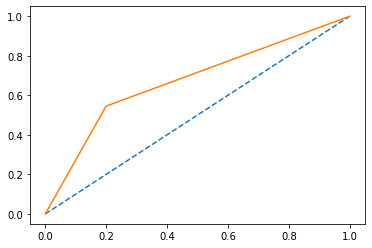

roc 0.6727272727272727
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


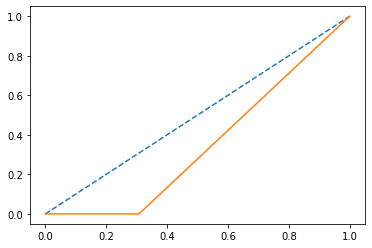

roc 0.34615384615384615
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


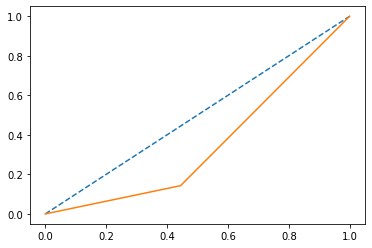

roc 0.3492063492063492
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


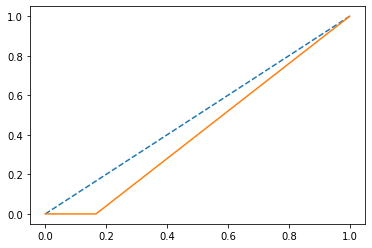

roc 0.4166666666666667
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


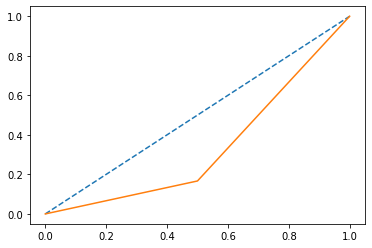

roc 0.33333333333333337
acc1 tensor(0.2500, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')


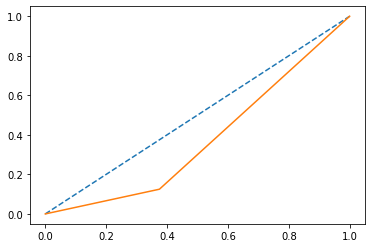

roc 0.375
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')


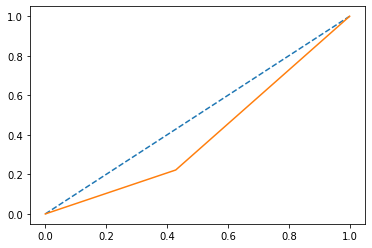

roc 0.39682539682539686
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


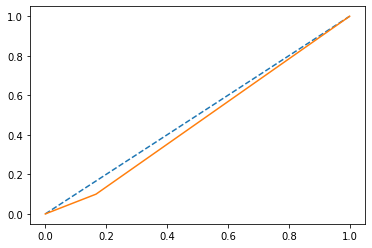

roc 0.46666666666666673
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


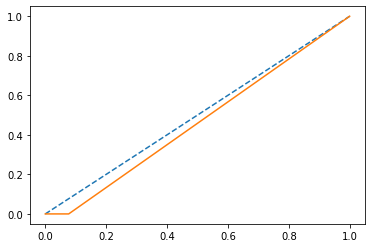

roc 0.46153846153846156
acc1 tensor(0.7500, device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


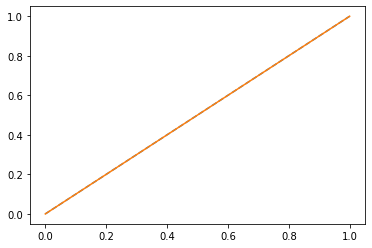

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


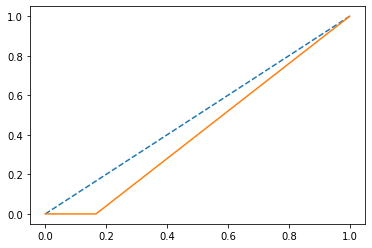

roc 0.4166666666666667
acc1 tensor(0.3125, device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


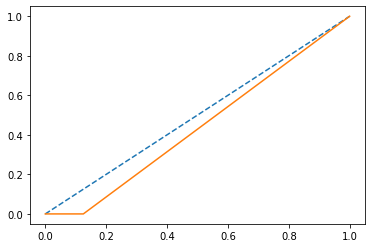

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')


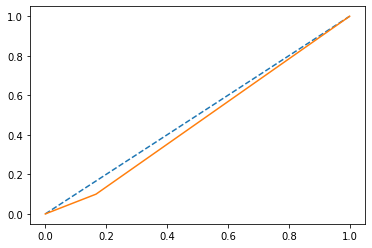

roc 0.46666666666666673
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')


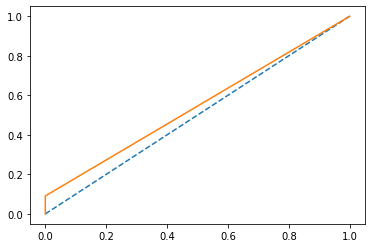

roc 0.5454545454545454
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


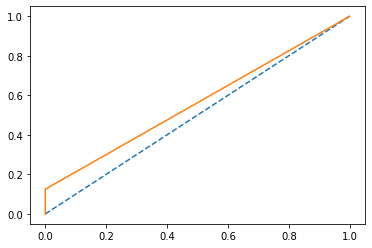

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


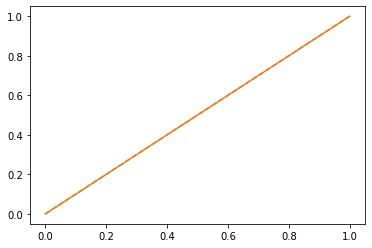

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


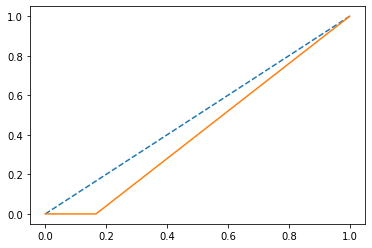

roc 0.4166666666666667
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


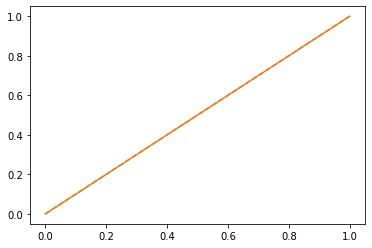

roc 0.5
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


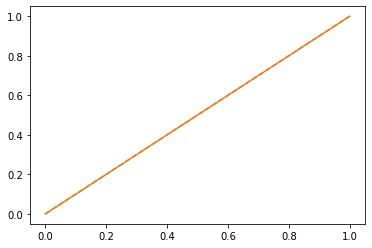

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


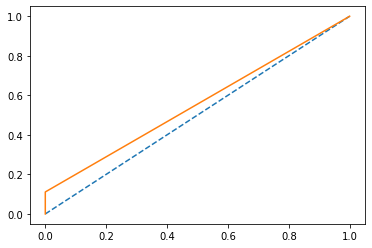

roc 0.5555555555555556
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


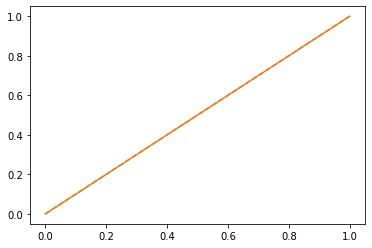

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


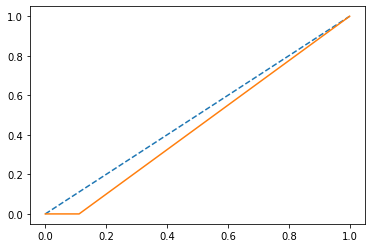

roc 0.4444444444444444
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


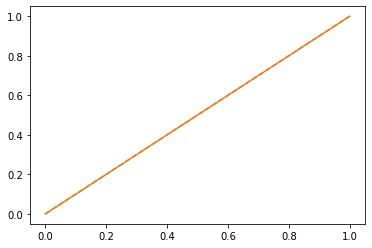

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


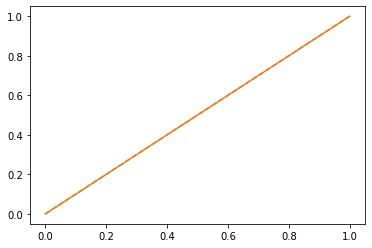

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


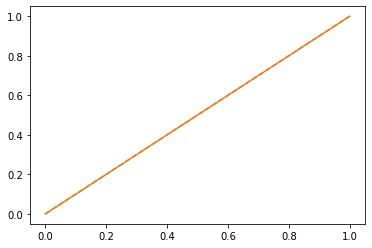

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


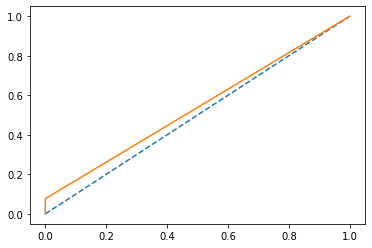

roc 0.5384615384615384
acc1 tensor(0.2500, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


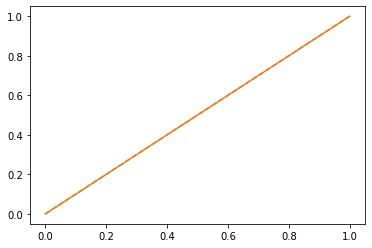

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


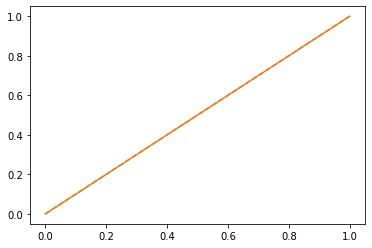

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


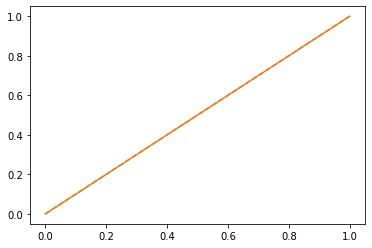

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


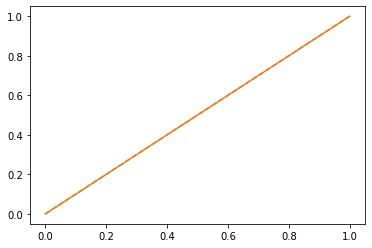

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


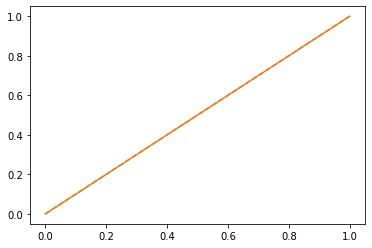

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


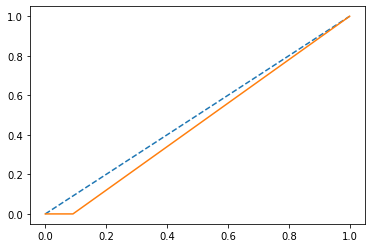

roc 0.45454545454545453
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


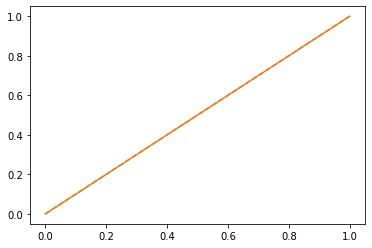

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


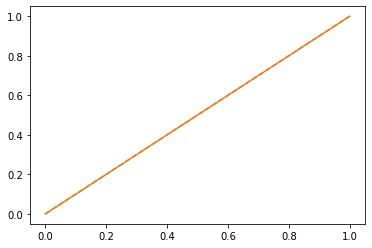

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


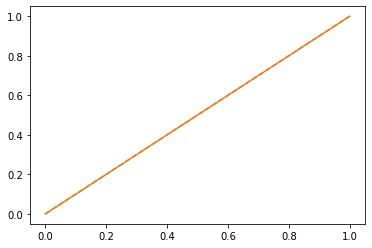

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


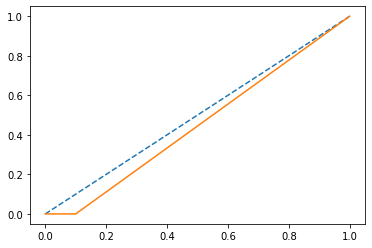

roc 0.45
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


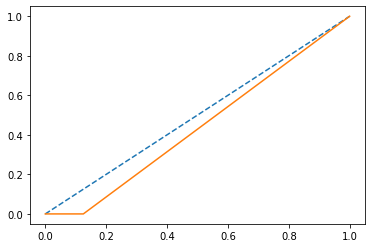

roc 0.4375
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


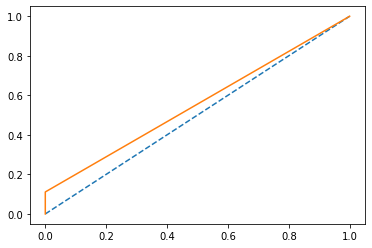

roc 0.5555555555555556
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


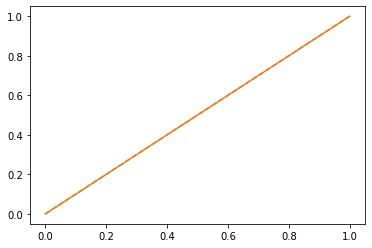

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


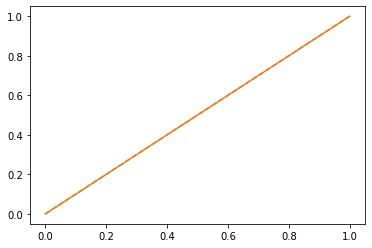

roc 0.5
acc1 tensor(0.2500, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


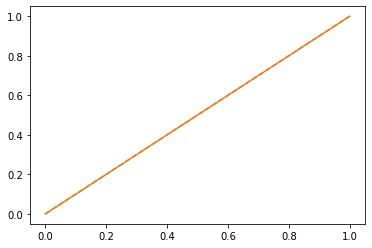

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


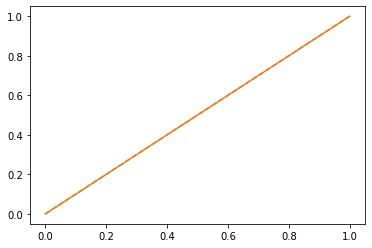

roc 0.5
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


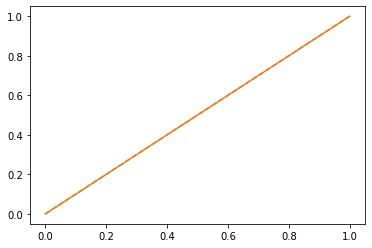

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


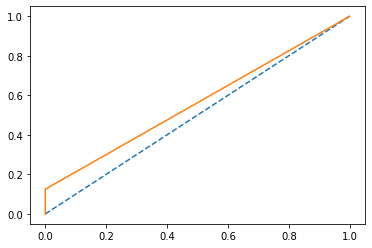

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


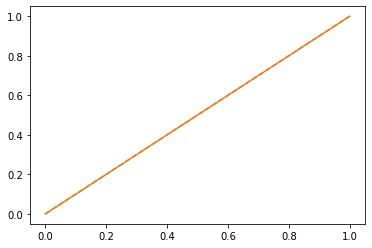

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


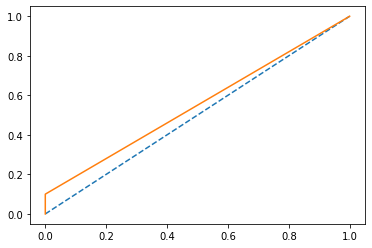

roc 0.55
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


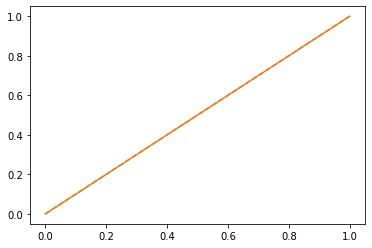

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


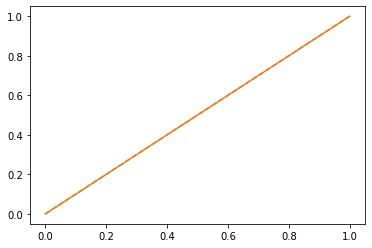

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


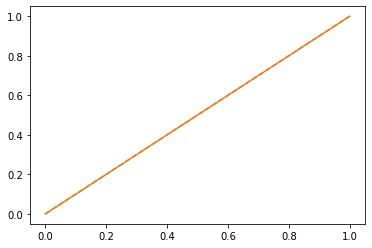

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


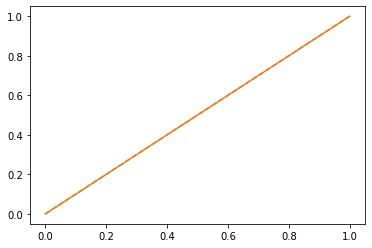

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


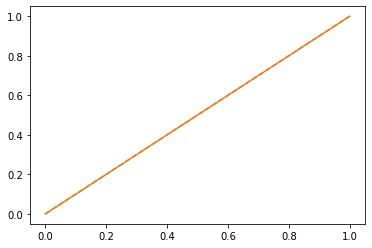

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


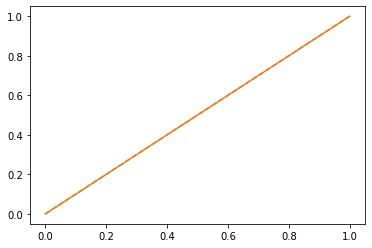

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


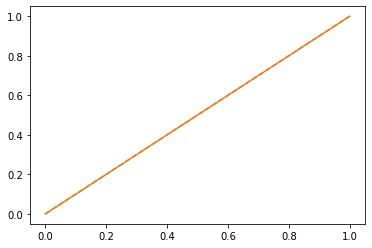

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


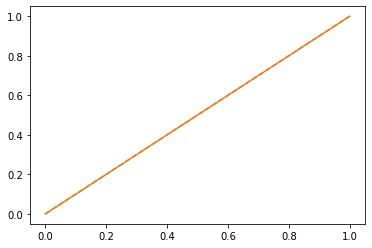

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


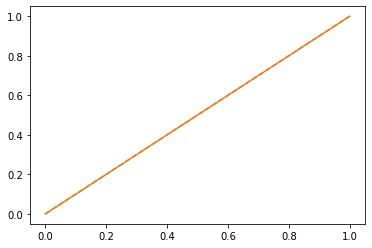

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


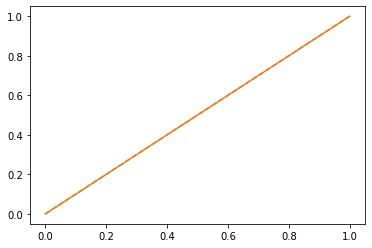

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


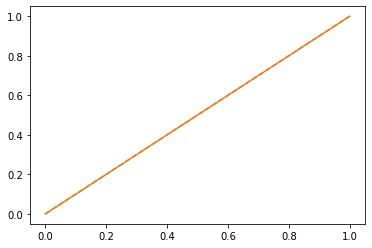

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


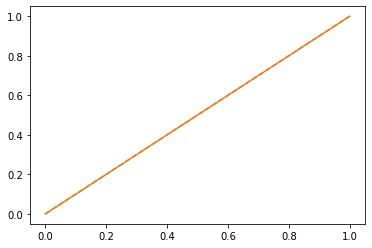

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


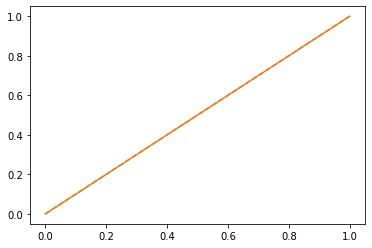

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


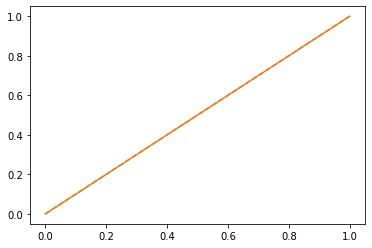

roc 0.5
acc1 tensor(0.6875, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


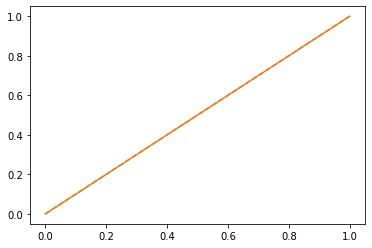

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


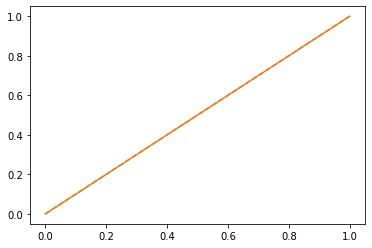

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


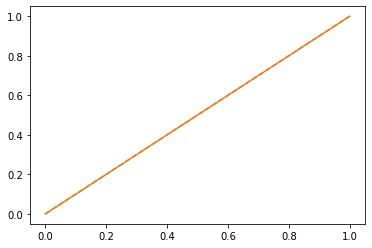

roc 0.5
acc1 tensor(0.8125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


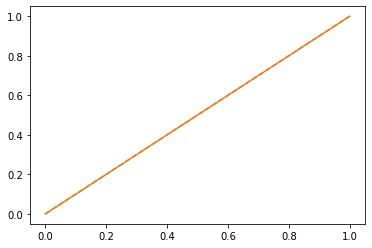

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


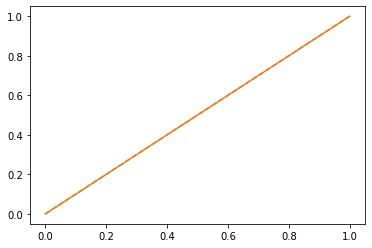

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


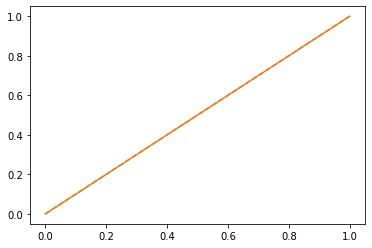

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


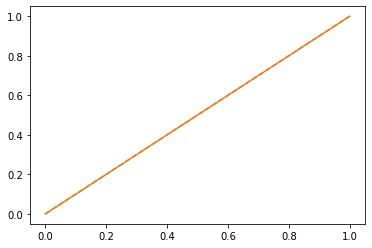

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


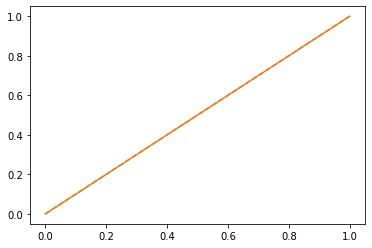

roc 0.5
acc1 tensor(0.6250, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


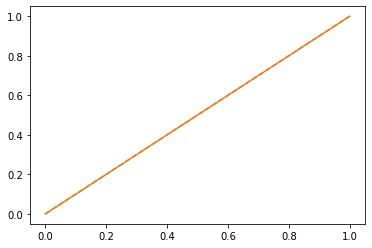

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


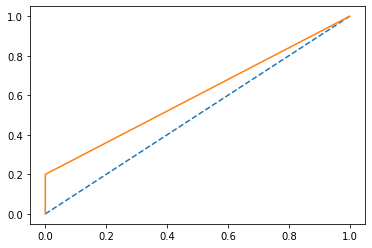

roc 0.6
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


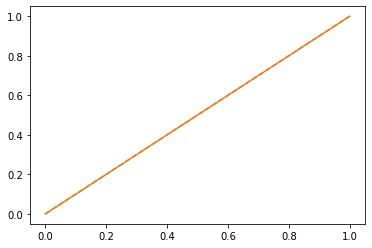

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


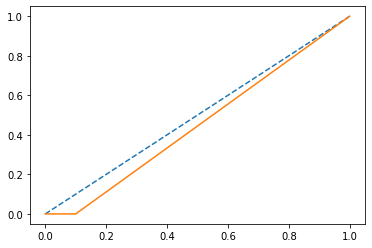

roc 0.45
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


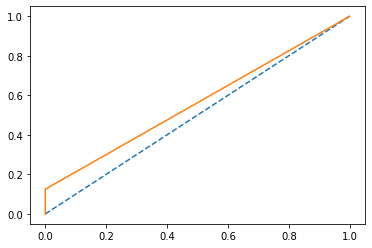

roc 0.5625
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


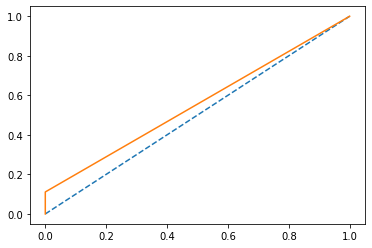

roc 0.5555555555555556
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


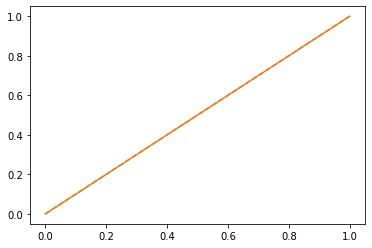

roc 0.5
acc1 tensor(0.3125, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


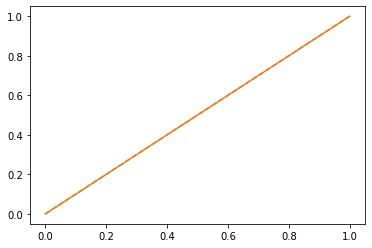

roc 0.5
acc1 tensor(0.3750, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


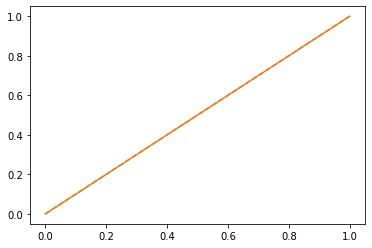

roc 0.5
acc1 tensor(0.4375, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


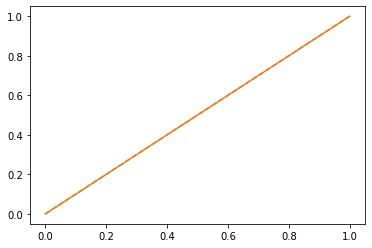

roc 0.5
acc1 tensor(0.5000, device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


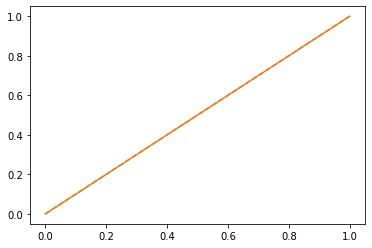

roc 0.5
acc1 tensor(0.5625, device='cuda:0')
pred tensor([0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


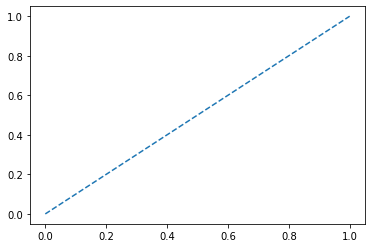

acc1 tensor(0., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


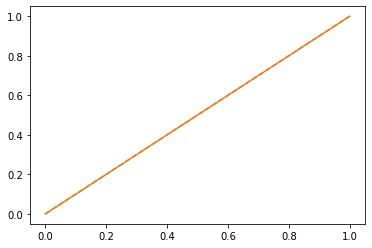

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


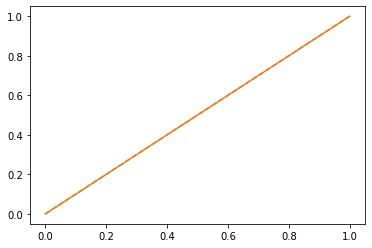

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


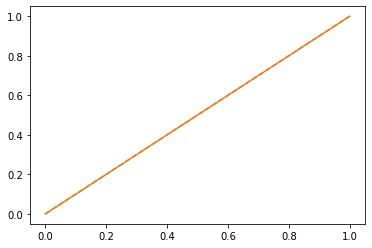

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


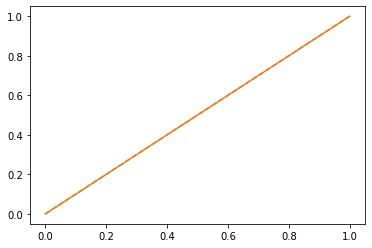

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


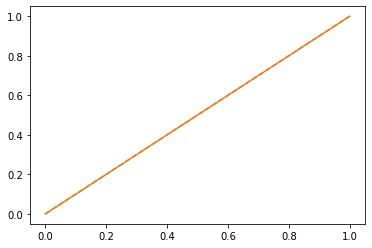

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


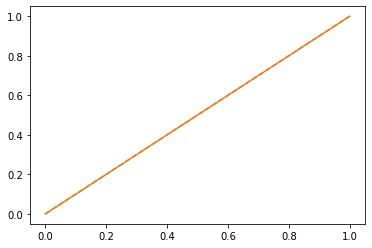

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


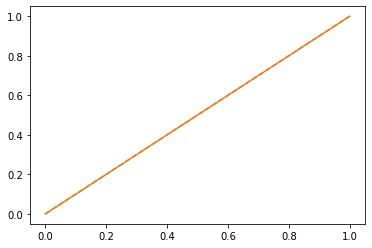

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


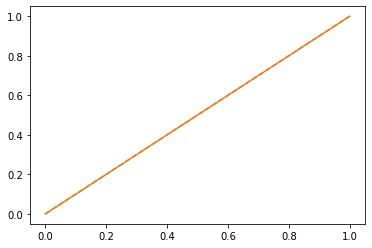

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


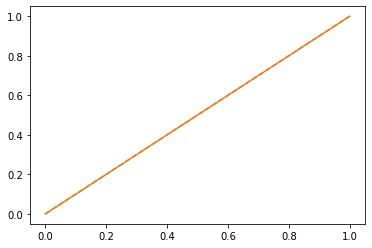

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


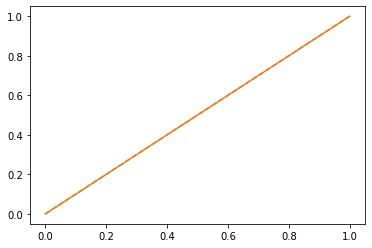

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


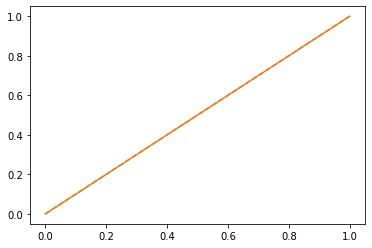

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


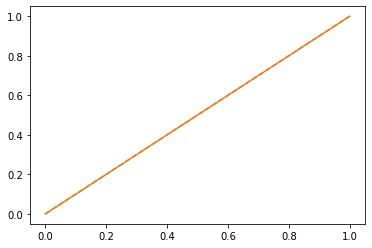

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


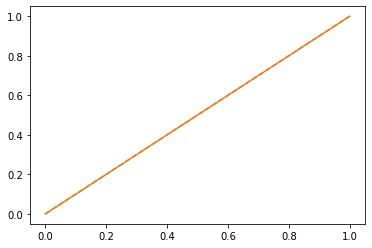

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


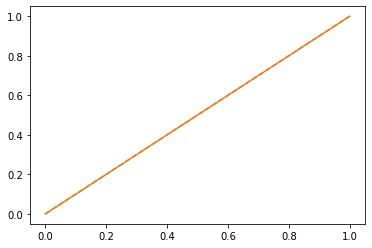

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


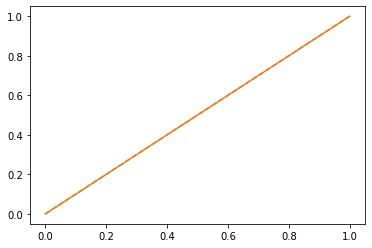

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


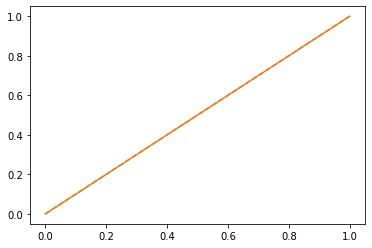

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


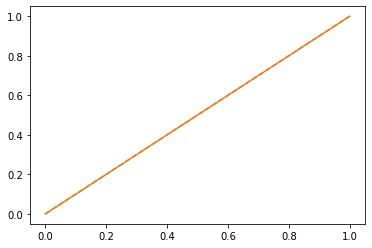

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


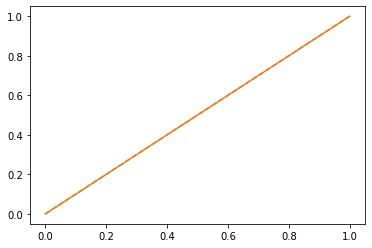

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


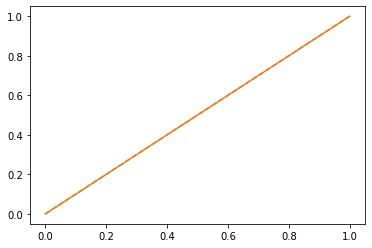

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


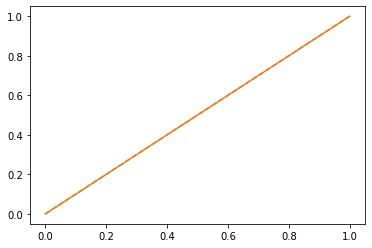

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


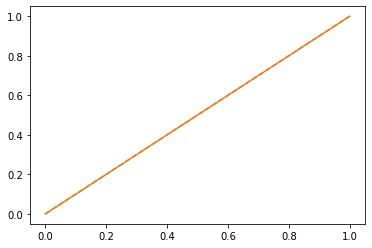

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


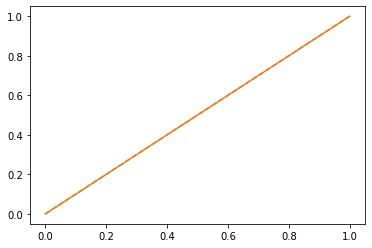

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


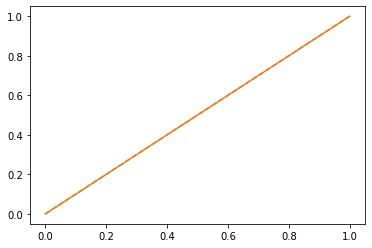

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


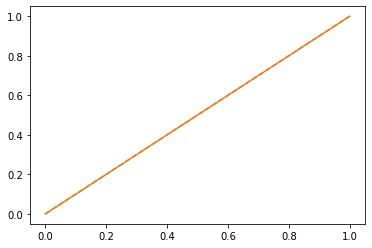

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


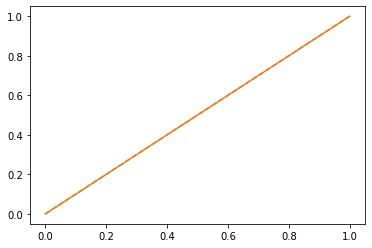

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


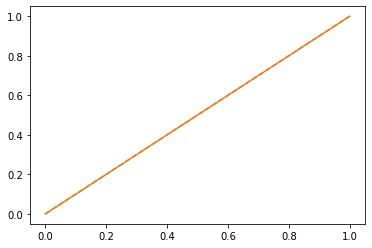

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


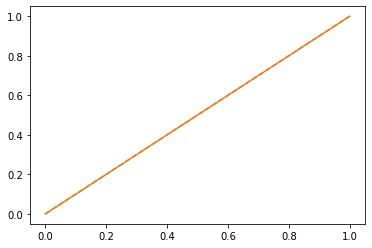

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


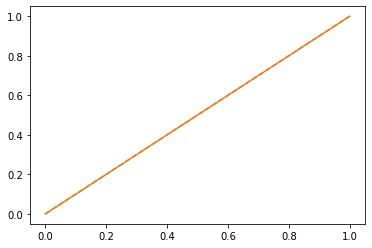

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


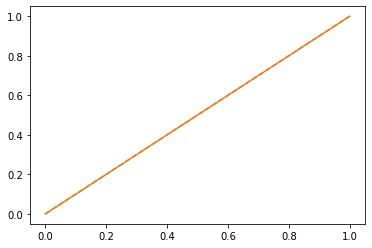

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


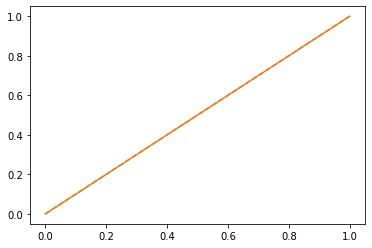

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


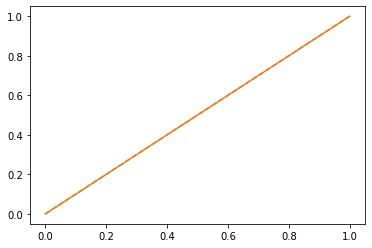

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


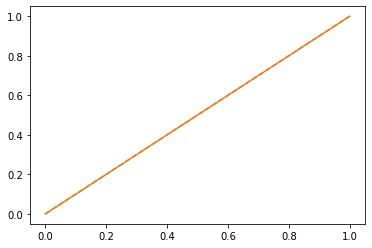

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


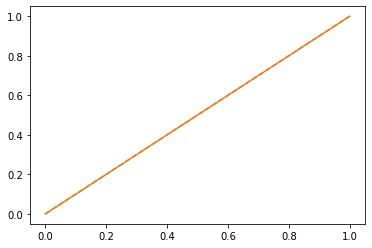

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


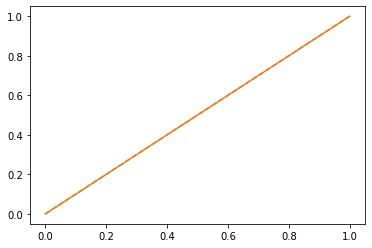

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


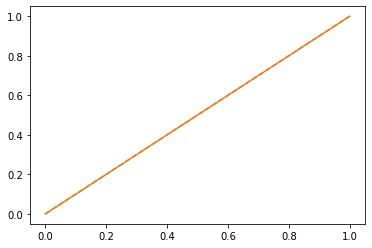

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


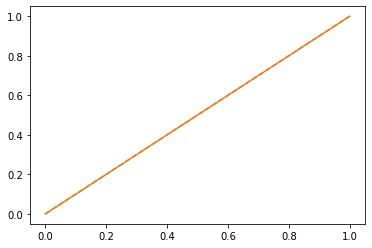

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


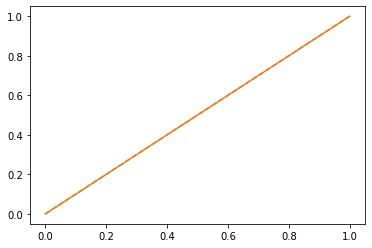

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


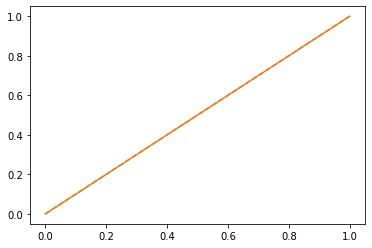

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


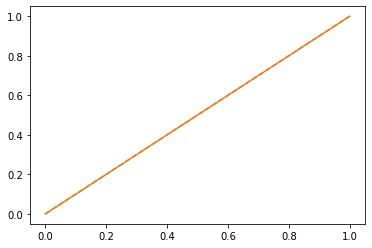

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


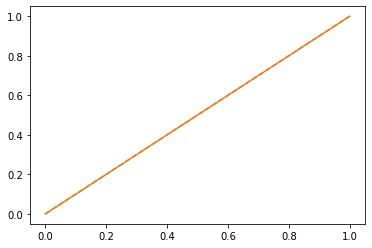

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


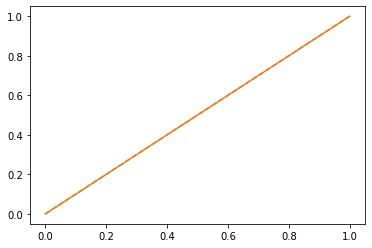

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


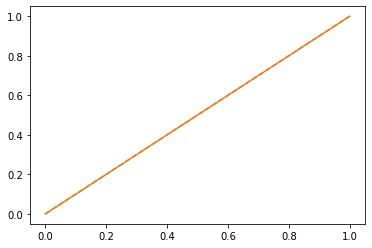

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


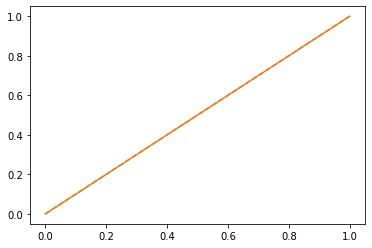

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


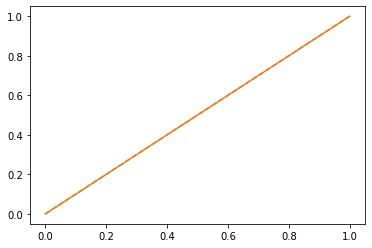

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


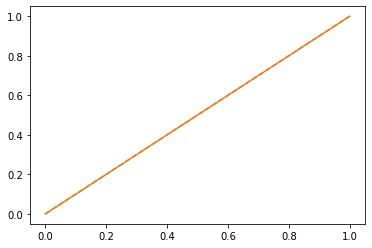

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


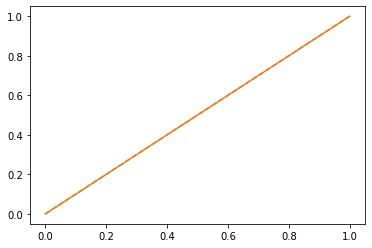

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


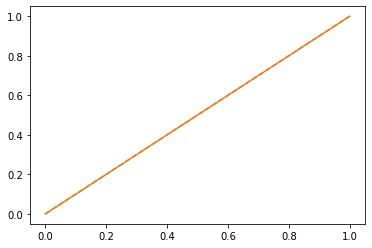

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


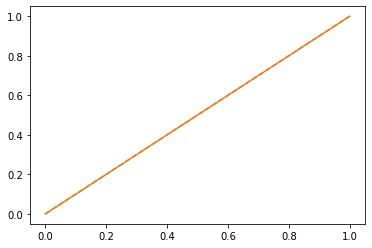

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


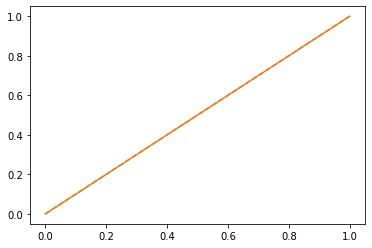

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


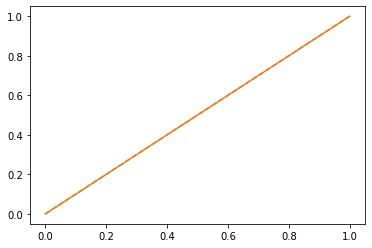

roc 0.5
pred tensor([0], device='cuda:0')
prob tensor([0], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


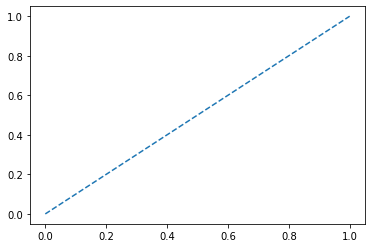

Epoch 1: train_loss: 0.6962 train_acc: 0.4876 | val_loss: 0.6954 val_acc: 0.5331
00:02:08.45
roc 562949953421311.5
num 2251799813685246
avg 0.25


In [ ]:
train(model, train_loader, val_loader, optimizer)

The average ROC value while considering only the iterations with values: 0.5001083403025925

The avergae ROC value while considering all the iterations: 0.46704948878159613